In [23]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
from desmin_reconstruction.plotting.renderings import render_boundingsquare
from desmin_reconstruction.preprocessing.bbox import BoundingSquare
from PIL import Image
from PIL.ExifTags import TAGS


plt.rc("font", size=12)
plt.rc("grid", linestyle="--", color="lightgray")
plt.rc("axes.spines", right=False, top=False)
pv.set_jupyter_backend("static")

datadir = Path("../data/")

COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00", "actin": "#0000FF"}

In [2]:
# img = Image.open(
#     datadir / "confocal/2_T32DN_denervated_desmin stainig_40X_DESMIN_image3.tif"
# )
img = Image.open(datadir / "STORM/desmin_260nm/2016-12-19-10-33-07_probe0.tif")

In [3]:
def parse_exif_data(exif_data):
    exif_dict = dict()
    for tag_id in exif_data:
        tag = TAGS.get(tag_id, tag_id)
        content = exif_data.get(tag_id)
        exif_dict[tag] = content
    return exif_dict

In [4]:
metadata = parse_exif_data(img.getexif())
print(metadata)

{'ImageWidth': 2048, 'ImageLength': 2048, 'BitsPerSample': 16, 'Compression': 1, 'PhotometricInterpretation': 1, 50839: b'IJIJover\x00\x00\x00\x02Iout\x00\xe4\x01\x00\x07\xc3\x07W\x07\xc7\x07\xd8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\x00S\x00B\x00|Iout\x00\xe4\x01\x00\x07\xc7\x07|\x07\xdc\x07\xb4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00v\x00\x00\x00\x0e\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00\t\x00S\x00a\x00n\x00S\x00e\x00r\x00i\x00f

In [5]:
img_data = np.array(img)

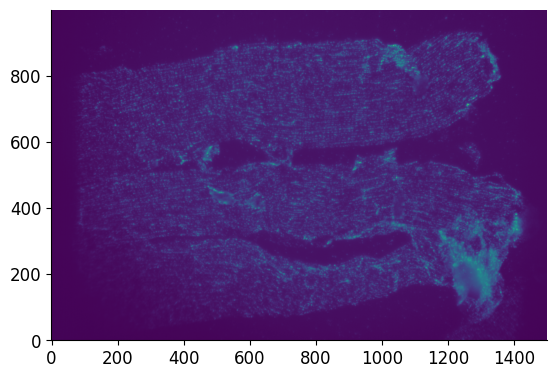

In [6]:
import matplotlib.pyplot as plt


plt.imshow(img_data[350:1350, 200:1700], origin="lower")

In [7]:
img_data_roi = img_data[350:1350, 200:1700].T
img_data_roi = img_data_roi[:, ::-1]

In [9]:
grid_shape = np.asarray(img_data_roi.shape + (1,)) + 1
pixel_sizes = (
    1e-3 / metadata["YResolution"],
    1e-3 / metadata["XResolution"],
    1e-3 / metadata["XResolution"],
)

grid = pv.ImageData(dimensions=grid_shape, spacing=pixel_sizes)
grid.cell_data["desmin"] = img_data_roi.flatten(order="F")

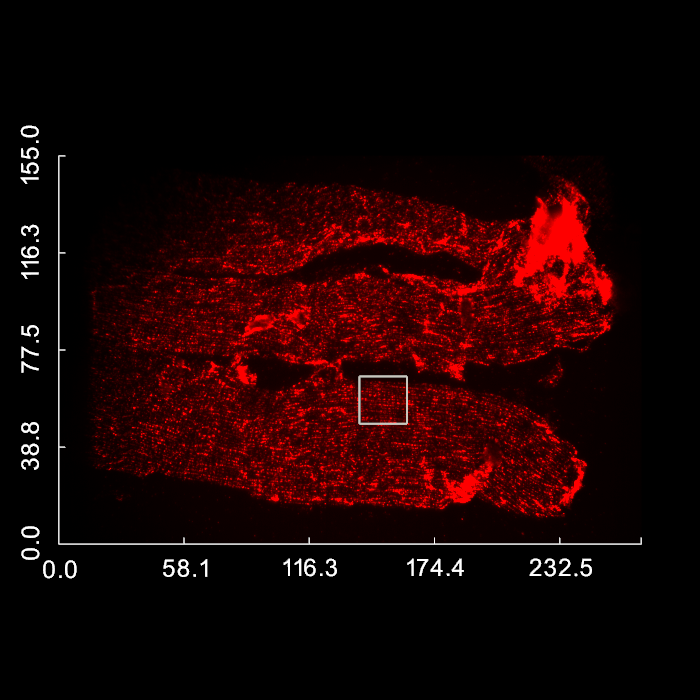

In [22]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
actor = p.add_volume(
    grid,
    cmap=["#FF0000"],
    opacity=[0.0, 0.1, 1.0],
    clim=(0, 300),
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
p.set_background(color="black")
p.enable_parallel_projection()

bbox = BoundingSquare(120.0, 48.0, side=19.0)
p = render_boundingsquare(p, bbox, line_width=2.0, color="white", z_height=1.0)

p.enable_parallel_projection()
p.view_xy()


axis = p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=18,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)

p.show()
p.save_graphic("../figures/fig_1/1c/full_view.svg")

In [24]:
# filepath = datadir / "STORM/desmin_260nm/2016-12-19-11-12-35.csv"
filepath = datadir / "STORM/desmin_260nm/2016-12-19-10-33-07.csv"
df = pl.read_csv(filepath)
df = df.with_columns(*[pl.col(i) / 1000 for i in ("x", "y", "z")])
df = df.with_columns(*[pl.col(i) - pl.col(i).min() for i in ("x", "y", "z")])
df.head()

image-ID,time-point,cycle,z-step,frame,accum,probe,photon-count,photon-count11,photon-count12,photon-count21,photon-count22,psfx,psfy,psfz,psf-photon-count,x,y,z,stdev,amp,background11,background12,background21,background22,maxResidualSlope,chisq,log-likelihood,llr,accuracy,fiducial,valid,precisionx,precisiony,precisionz,cluster-ID,particle-ID
i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,0,0,0,0,1,0,1252.68,0,0,0,0,21.2169,55.3532,19.2242,1035.79,9.859219,13.951713,0.292219,0,35.609,26.4716,30.7773,0,0,0,122.09,-829.852,0,0,0,1,0,0,0,0,-1
0,0,0,0,0,1,0,1226.47,0,0,0,0,12.2247,133.875,-169.344,839.349,6.280419,16.763313,0.480787,0,28.9534,23.8035,29.2058,0,0,0,158.866,-837.312,0,0,0,1,0,0,0,0,-1
0,0,0,0,0,1,0,1234.34,0,0,0,0,29.1229,61.5517,55.7145,1123.86,7.160459,15.041813,0.255728,0,38.7211,26.8101,31.7938,0,0,0,72.8863,-806.555,0,0,0,1,0,0,0,0,-1
0,0,0,0,0,1,0,1634.57,0,0,0,0,1.06623,96.2198,127.393,1721.82,1.408229,10.921113,0.18405,0,60.1023,23.8562,27.8991,0,0,0,90.5522,-806.868,0,0,0,1,0,0,0,0,-1
0,0,0,0,0,1,0,1125.32,0,0,0,0,178.39,-72.5006,-114.773,834.286,18.771119,7.502033,0.426216,0,29.4252,25.8965,30.2114,0,0,0,62.8884,-790.633,0,0,0,1,0,0,0,0,-1


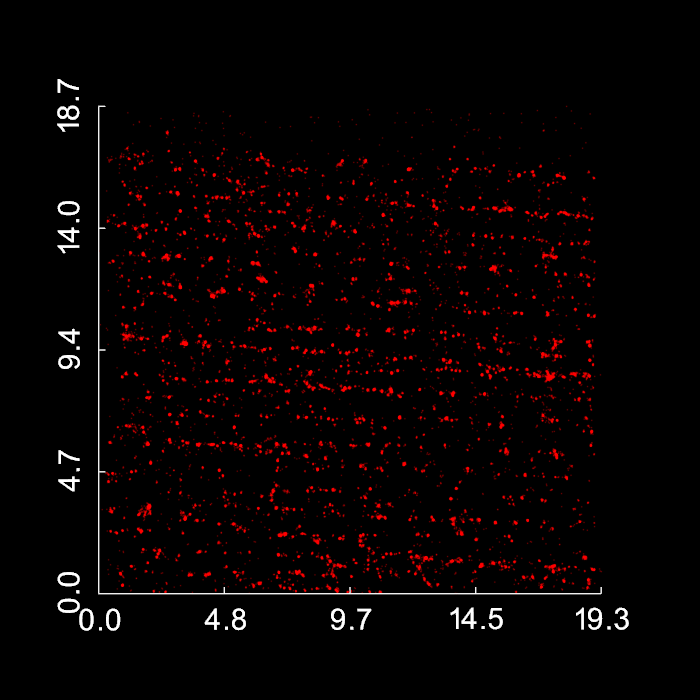

In [27]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
point_cloud = pv.PolyData(df.select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#FF0000",
    style="points_gaussian",
    # emissive=True,
    point_size=1,
    opacity=0.4,
)

p.set_background(color="black")
p.enable_parallel_projection()

p.view_xy()
axis = p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
# axis.x_axis_label_visibility = False
# axis.y_axis_label_visibility = False
# p.camera.tight(padding=0.2)
p.show()
p.save_graphic("../figures/fig_1/1c/roi.svg")